# Example: Optimal Point on the Captial Allocation Line
The Utility function most often used when selected an optimal location on the the Captial Allocation Line (CAL) takes the form:

$$
U(\theta,A) = r_{f}+\theta\cdot\left(\mathbb{E}(r_{\mathcal{P}}) - r_{f}\right) - \left(\frac{A}{2}\right)\theta^{2}\sigma_{\mathcal{P}}^{2}
$$

where $r_{f}$ denotes the risk free rate and $\theta$ denotes fraction of risky assets, i.e., the position along the capital allocation line; $\theta = 0$ indicates only the risk-free asset is selected, and $\theta = 1$ denotes only risky assets are selected. The term $A$ is the _risk aversion_ parameter. Finally, the terms $\mathbb{E}(r_{\mathcal{P}})$ and $\sigma_{\mathcal{P}}^{2}$ denote the expected return and variance of the _tangent portfolio_.

### Learning Objectives
Fill me in

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Manifest.toml`
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


budget (generic function with 1 method)

### Historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) for the past five-trading years (a maximum of `1256` data points per firm). However, not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or delisted, etc. We will exclude these firms from the `dataset`.

We load the price `dataset` by calling the `MyPortfolioDataSet()` function:

In [2]:
dataset = MyPortfolioDataSet() |> x-> x["dataset"];

While it is sometimes convenient to work with the data using the `firm_index`, often we want to specify the [ticker symbol](https://en.wikipedia.org/wiki/Ticker_symbol#:~:text=A%20ticker%20symbol%20or%20stock,on%20a%20particular%20stock%20market.) instead. To facilitate this, let's load a mapping between the `firm_index` and the ticker symbols using the `MyFirmMappingDataSet()` function:

In [3]:
firm_mapping = MyFirmMappingDataSet()

Row,Symbol,Name,Sector
,String7,String,String31
1,MMM,3M,Industrials
2,AOS,A. O. Smith,Industrials
3,ABT,Abbott Laboratories,Health Care
4,ABBV,AbbVie,Health Care
5,ABMD,Abiomed,Health Care
6,ACN,Accenture,Information Technology
7,ATVI,Activision Blizzard,Communication Services
8,ADM,ADM,Consumer Staples
9,ADBE,Adobe,Information Technology


In [4]:
ticker_lookup_dictionary = Dict{String,Int64}();
number_of_map_elements = nrow(firm_mapping);
for i ∈ 1:number_of_map_elements
    ticker = firm_mapping[i,:Symbol];
    ticker_lookup_dictionary[ticker] = i;
end

Each firm is assigned an `index` (the `keys` of the `dataset` dictionary). Let's specify a list of `tickers` and look up the corresponding `firm_index` from the `ticker_lookup_dictionary`. We'll hold the indexes of the firms we are interested in in the `firms` array:

In [5]:
tickers = ["AAPL", "WFC", "BAC", "GM", "F", "AMD", "INTC", "MU", "PFE", "PG"];
firms = Array{Int64,1}();
for ticker ∈ tickers
    firm_index = ticker_lookup_dictionary[ticker];
    push!(firms, firm_index)
end

Finally, we set some constant values that are used in the computation of the efficient frontier and the capital allocation line:

In [6]:
number_of_firms = length(firms);
initial = zeros(number_of_firms);
initial[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.045
number_of_points = 20;

### Task 2: Compute the expected return and covariance matrices
First, we compute the expected (annualized) log return by passing the `dataset` and a list of firms we are interested in (held in the $N\times{1}$ `firms` array) to the `log_return_matrix(...)` method. The result is stored in the `return_matrix` variable, a $T-1\times{N}$ array of log return values. 
Each row of `return_matrix` corresponds to a time-value, while each column corresponds to a firm: 

In [7]:
return_matrix = log_return_matrix(dataset, firms; Δt = (1/252));

Next, we estimate the `covariance_matrix` from the `return_matrix` using the `cov(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/): 

In [8]:
covariance_matrix = (1/100)*cov(return_matrix);

In [9]:
covariance_matrix

10×10 Matrix{Float64}:
 0.192699   0.0733172  0.0861457  …  0.141104   0.0460831  0.0448453
 0.0733172  0.261418   0.209288      0.140748   0.0551668  0.0398724
 0.0861457  0.209288   0.238909      0.152769   0.0541595  0.0388589
 0.107984   0.184925   0.197339      0.198862   0.0492568  0.0319693
 0.102092   0.177707   0.177928      0.182283   0.0485853  0.0348232
 0.164661   0.0985639  0.117677   …  0.245292   0.0634407  0.0401605
 0.106321   0.0953592  0.0998742     0.180779   0.0486804  0.037036
 0.141104   0.140748   0.152769      0.421905   0.0473042  0.0356968
 0.0460831  0.0551668  0.0541595     0.0473042  0.134575   0.0374414
 0.0448453  0.0398724  0.0388589     0.0356968  0.0374414  0.0843364

Finally, we estimate the expected return for each firm from the `return_matrix` using the `mean(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/): 

In [10]:
expected_return = mean(return_matrix, dims=1) |> vec |> x-> exp.(x) .- 1

10-element Vector{Float64}:
  0.2448236308641849
 -0.07734788985258878
  0.021227098258744803
 -0.04712736155895825
 -0.0196654319809495
  0.40686522002755066
 -0.10240153551931819
  0.021378949587838925
  0.06945676547287949
  0.10848055066674744

### Task 3: Compute the efficient frontier (risky assets only)
First, let's create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable, using the `build(...)` method. We pass the covariance array estimated from data, and the expected return value, along with bounds and an initial guess to the `build(...)` method:

In [11]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = covariance_matrix,
    μ = expected_return,
    bounds = bounds,
    initial = initial,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable:

In [12]:
minimum_desired_reward_array = range(risk_free_rate, stop = 10*risk_free_rate, 
    length = number_of_points) |> collect;

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward
* We then pass the updated `problem_risk` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `efficient_frontier` dictionary.

In [13]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem_risk)

    # check: did this converge?
    status_flag = solution["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution["objective_value"]);
        value = solution["reward"];
        efficient_frontier[key] = value;
    end
end

### Task 4: Optimal allocation with risky and risk-free assets
Finally, let's create an instance of the `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` type, and store this in the `problem_risk_free` variable, using the `build(...)` method. We pass the covariance array estimated from data, and the expected return value, along with bounds, an initial guess and the risk free rate to the `build(...)` method:

In [14]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = covariance_matrix,
    μ = expected_return,
    bounds = bounds,
    initial = initial,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level, in the presence of a risk-free asset, using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward
* We then pass the updated `problem_risk_free` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution_risk_free` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary.

In [15]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_risk_free = solve(problem_risk_free)

    # check: did this converge?
    status_flag = solution_risk_free["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_risk_free["objective_value"]);
        value = solution_risk_free["reward"];
        capital_allocation_line[key] = value;
    end
end
capital_allocation_line;

In [16]:
minimum_desired_reward_array

20-element Vector{Float64}:
 0.045
 0.0663157894736842
 0.08763157894736842
 0.10894736842105263
 0.13026315789473683
 0.15157894736842104
 0.17289473684210524
 0.19421052631578944
 0.21552631578947368
 0.23684210526315788
 0.2581578947368421
 0.27947368421052626
 0.3007894736842105
 0.32210526315789473
 0.3434210526315789
 0.36473684210526314
 0.3860526315789473
 0.40736842105263155
 0.4286842105263157
 0.44999999999999996

#### Visualize the capital allocation line

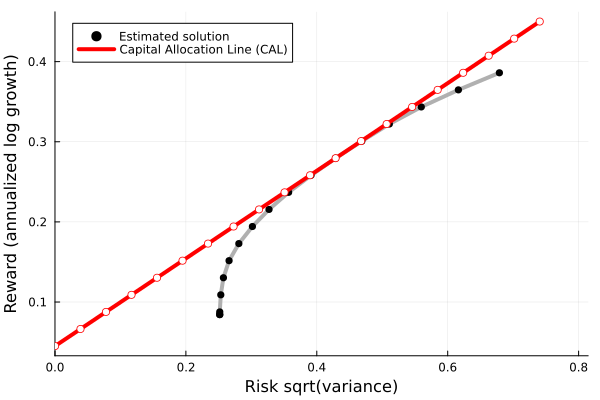

In [17]:
plot(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (log return)", fontsize=18, label="", c=:gray69, 
    xlim=(0.0, 1.1*maximum(efficient_frontier).first))
scatter!(efficient_frontier, label="Estimated solution", c=:black)
plot!(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (annualized log growth)", fontsize=18, c=:red, 
    xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
scatter!(capital_allocation_line, label="", msc=:red, mc=:white)

In [18]:
capital_allocation_line

Dict{Float64, Float64} with 20 entries:
  0.54569     => 0.343421
  0.506712    => 0.322105
  0.233867    => 0.172895
  0.389778    => 0.258158
  0.584668    => 0.364737
  0.194889    => 0.151579
  0.0779558   => 0.0876316
  0.000121801 => 0.0450184
  0.116934    => 0.108947
  0.662623    => 0.407368
  0.701601    => 0.428684
  0.155911    => 0.130263
  0.428756    => 0.279474
  0.467734    => 0.300789
  0.350801    => 0.236842
  0.272845    => 0.194211
  0.740579    => 0.45
  0.311823    => 0.215526
  0.0389781   => 0.0663158
  0.623645    => 0.386053

### Task 5: Utility as a function of the risk-aversion parameter $\tau$

In [19]:
problem_risk_free.R = 0.234;
solution_tangent_portfolio = solve(problem_risk_free)

Dict{String, Any} with 4 entries:
  "argmax"          => [0.374164, 4.46385e-11, 6.68819e-9, -7.97956e-10, 8.8107…
  "reward"          => 0.234
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.119442

In [60]:
variance = solution_tangent_portfolio["objective_value"]
θ̂ = (problem_risk_free.R - risk_free_rate)/(A*variance);

In [75]:
A = 20
number_of_indifference_points = 20
indifference_curve = Array{Float64,2}(undef,number_of_indifference_points,2)
σ_array = range(0.0, 0.2, length=number_of_indifference_points) |> collect
U_target = 0.054;
for i ∈ 1:number_of_indifference_points
    σ = σ_array[i]
    return_value = U_target + (A/2)*σ^2
    indifference_curve[i,1] = σ
    indifference_curve[i,2] = return_value
end

In [71]:
risk_value = θ̂*sqrt(variance);
reward_value = θ̂*(problem_risk_free.R)+(1-θ̂)*problem_risk_free.risk_free_rate;

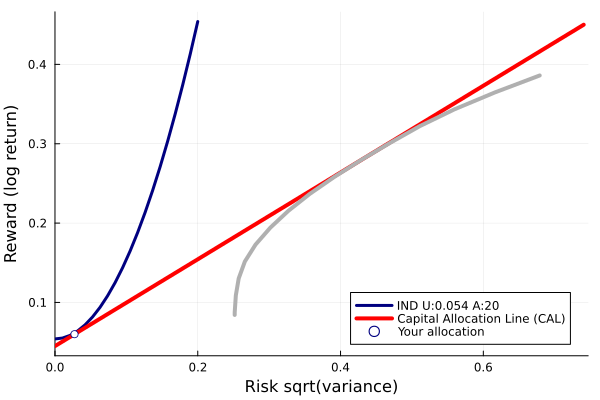

In [76]:
plot(indifference_curve[:,1], indifference_curve[:,2], lw=3, c=:navyblue, label="IND U:$(U_target) A:$(A)")
plot!(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (annualized log growth)", fontsize=18, c=:red, 
    xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
plot!(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (log return)", fontsize=18, label="", c=:gray69, 
    xlim=(0.0, 1.1*maximum(efficient_frontier).first))
scatter!([risk_value], [reward_value], msc=:navyblue, mc=:white, ms=4, label="Your allocation")